# Quickstart Example of Off-Policy Evaluation of Online Bandit Algorithms
---
This notebook provides an example of conducting OPE of online bandit algorithms using Replay Method (RM) with synthetic bandit feedback data.
RM uses a subset of the logged bandit feedback data where actions selected by the behavior policy are the same as that of the evaluation policy.
Theoretically, RM is unbiased when the behavior policy is uniformly random and the evaluation policy is fixed.
However, empirically, RM works well when evaluation policies are learning algorithms.
Please refer to https://arxiv.org/abs/1003.5956 about the details of RM.

Our example with online bandit algorithms contains the following three major steps:
- (1) Synthetic Data Generation
- (2) Off-Policy Evaluation (OPE)
- (3) Evaluation of OPE

Please see [../examples/online](../online) for a more sophisticated example of the evaluation of OPE of online bandit algorithms.

In [1]:
# needed when using Google Colab
# !pip install obp

In [2]:
# import open bandit pipeline (obp)
import obp
from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function
)
from obp.policy import EpsilonGreedy, LinTS, LinUCB
from obp.ope import (
    OffPolicyEvaluation, 
    ReplayMethod
)
from obp.simulator import (
    calc_ground_truth_policy_value,
)

In [3]:
# obp version
print(obp.__version__)

0.5.4


## (1) Synthetic Data Generation
We prepare easy-to-use synthetic data generator: `SyntheticBanditDataset` class in the dataset module.

It takes number of actions (`n_actions`), dimension of context vectors (`dim_context`), reward function (`reward_function`), and behavior policy (`behavior_policy_function`) as inputs and generates a synthetic bandit dataset that can be used to evaluate the performance of decision making policies (obtained by `off-policy learning`) and OPE estimators.

In [4]:
# generate a synthetic bandit dataset with 10 actions
# we use `logistic function` as the reward function
# we use the uniformly random behavior policy because it is desriable for RM
# one can define their own reward function and behavior policy such as nonlinear ones. 
dataset = SyntheticBanditDataset(
    n_actions=10,
    dim_context=5,
    reward_type="binary", # "binary" or "continuous"
    reward_function=logistic_reward_function,
    behavior_policy_function=None, # uniformly random
    random_state=12345,
)
# obtain a set of synthetic logged bandit feedback
n_rounds = 10000
bandit_feedback = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds)

# `bandit_feedback` is a dictionary storing synthetic logged bandit data
bandit_feedback

{'n_rounds': 10000,
 'n_actions': 10,
 'context': array([[-0.20470766,  0.47894334, -0.51943872, -0.5557303 ,  1.96578057],
        [ 1.39340583,  0.09290788,  0.28174615,  0.76902257,  1.24643474],
        [ 1.00718936, -1.29622111,  0.27499163,  0.22891288,  1.35291684],
        ...,
        [-1.27028221,  0.80914602, -0.45084222,  0.47179511,  1.89401115],
        [-0.68890924,  0.08857502, -0.56359347, -0.41135069,  0.65157486],
        [ 0.51204121,  0.65384817, -1.98849253, -2.14429131, -0.34186901]]),
 'action_context': array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]),
 'action': array([9, 3, 2, ..., 0, 2, 7]),
 'position': None,
 're

## (2) Off-Policy Evaluation (OPE)
Our next step is OPE which aims to estimate the performance of online bandit algorithms using logged bandit data and RM.

Here, we visualize the OPE results.

In [5]:
# simulations of online bandit algorithms
# obtain a deterministic action distribution representing which action is selected at each round in the simulation
# policies are updated only when the selected action is the same as that of the logged data
epsilon_greedy = EpsilonGreedy(
    n_actions=dataset.n_actions,
    epsilon=0.1,
    random_state=12345
)
action_dist_epsilon_greedy = run_bandit_replay(
    bandit_feedback=bandit_feedback,
    policy=epsilon_greedy
)

lin_ts = LinTS(
    dim=dataset.dim_context,
    n_actions=dataset.n_actions,
    random_state=12345
)
action_dist_lin_ts = run_bandit_replay(
    bandit_feedback=bandit_feedback,
    policy=lin_ts
)

lin_ucb = LinUCB(
    dim=dataset.dim_context,
    n_actions=dataset.n_actions,
    random_state=12345
)
action_dist_lin_ucb = run_bandit_replay(
    bandit_feedback=bandit_feedback,
    policy=lin_ucb
)

100%|██████████| 10000/10000 [00:00<00:00, 10100.23it/s]


In [6]:
# estimate the policy value of the online bandit algorithms using RM
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback,
    ope_estimators=[ReplayMethod()]
)

    95.0% CI (lower)  95.0% CI (upper)     mean
rm          0.548577          0.633734  0.59423 



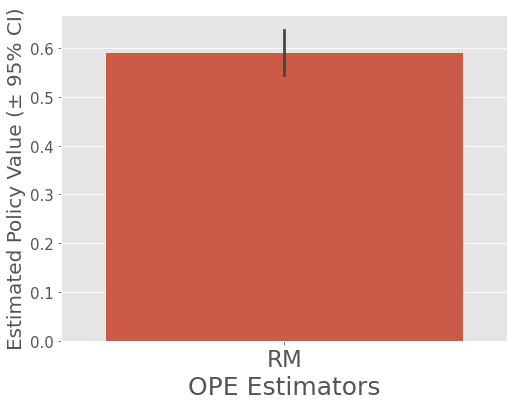

In [7]:
# estimate the policy value of EpsilonGreedy
estimated_policy_value_epsilon_greedy, estimated_interval_epsilon_greedy = ope.summarize_off_policy_estimates(
    action_dist=action_dist_epsilon_greedy
)
print(estimated_interval_epsilon_greedy, '\n')

# visualize estimated policy values of EpsilonGreedy by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    action_dist=action_dist_epsilon_greedy,
    n_bootstrap_samples=10000, # number of resampling performed in bootstrap sampling
    random_state=12345,
)

    95.0% CI (lower)  95.0% CI (upper)      mean
rm          0.615827          0.712571  0.662281 



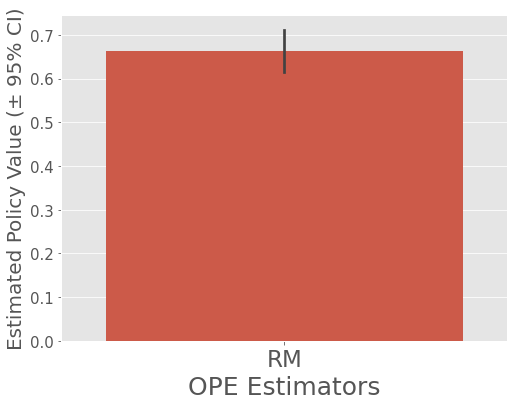

In [8]:
# estimate the policy value of LinTS
estimated_policy_value_lin_ts, estimated_interval_lin_ts = ope.summarize_off_policy_estimates(
    action_dist=action_dist_lin_ts
)
print(estimated_interval_lin_ts, '\n')

# visualize estimated policy values of LinTS by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    action_dist=action_dist_lin_ts,
    n_bootstrap_samples=10000, # number of resampling performed in bootstrap sampling
    random_state=12345,
)

    95.0% CI (lower)  95.0% CI (upper)      mean
rm          0.581798          0.674513  0.626882 



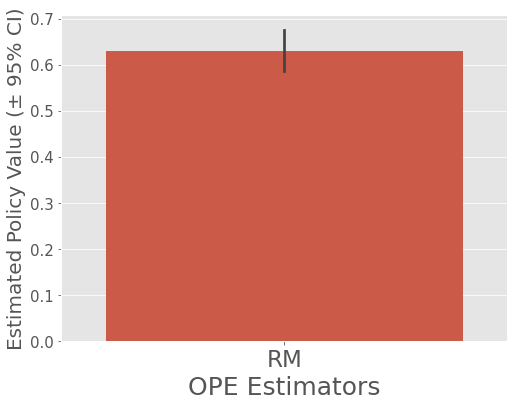

In [9]:
# estimate the policy value of LinUCB
estimated_policy_value_lin_ucb, estimated_interval_lin_ucb = ope.summarize_off_policy_estimates(
    action_dist=action_dist_lin_ucb
)
print(estimated_interval_lin_ucb, '\n')

# visualize estimated policy values of LinUCB by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    action_dist=action_dist_lin_ucb,
    n_bootstrap_samples=10000, # number of resampling performed in bootstrap sampling
    random_state=12345,
)

RM estimates that LinTS is the best policy.

## (3) Evaluation of OPE
Our final step is **the evaluation of OPE**, which evaluates and compares the estimation accuracy of OPE estimators.

With synthetic data, we can calculate the policy value of the evaluation policies. 
Therefore, we can compare the policy values estimated by RM with the ground-turths to evaluate the accuracy of OPE.

In [10]:
# we first calculate the policy values of the three evaluation policies
# in synthetic data, we know p(r|x,a), the reward distribution, so we can perform simulations
# here, a policy is updated at each round according to actions and rewards sampled from the policy and p(r|x,a)
# the policy values are averaged over `n_sim` simulations
policy_value_epsilon_greedy = calc_ground_truth_policy_value(
    bandit_feedback=bandit_feedback,
    reward_sampler=dataset.sample_reward, # p(r|x,a)
    policy=epsilon_greedy,
    n_sim=3 # the number of simulations
)
policy_value_lin_ts = calc_ground_truth_policy_value(
    bandit_feedback=bandit_feedback,
    reward_sampler=dataset.sample_reward, # p(r|x,a)
    policy=lin_ts,
    n_sim=3 # the number of simulations
)
policy_value_lin_ucb = calc_ground_truth_policy_value(
    bandit_feedback=bandit_feedback,
    reward_sampler=dataset.sample_reward, # p(r|x,a)
    policy=lin_ucb,
    n_sim=3 # the number of simulations
)

print(f'policy value of EpsilonGreedy: {policy_value_epsilon_greedy}')
print(f'policy value of LinTS: {policy_value_lin_ts}')
print(f'policy value of LinUCB: {policy_value_lin_ucb}')

100%|██████████| 3/3 [00:21<00:00,  7.24s/it]

policy value of EpsilonGreedy: 0.6056001659264234
policy value of LinTS: 0.7515744188226375
policy value of LinUCB: 0.6689063585401301


In fact, LinTS reveals the best performance among the three evaluation policies.

Using the above policy values, we evaluate the estimation accuracy of the OPE estimators.

In [11]:
# evaluate the estimation performances of OPE estimators 
# by comparing the estimated policy values of EpsilonGreedy and its ground-truth.
# `summarize_estimators_comparison` returns a pandas dataframe containing estimation performances of given estimators 
relative_ee_epsilon_greedy = ope.summarize_estimators_comparison(
    ground_truth_policy_value=policy_value_epsilon_greedy,
    action_dist=action_dist_epsilon_greedy,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performances of the three estimators (lower means accurate)
relative_ee_epsilon_greedy

,relative-ee
rm,0.02448


In [12]:
# evaluate the estimation performance of OPE estimators 
# by comparing the estimated policy values of LinTS t and its ground-truth.
# `summarize_estimators_comparison` returns a pandas dataframe containing estimation performances of given estimators 
relative_ee_lin_ts = ope.summarize_estimators_comparison(
    ground_truth_policy_value=policy_value_lin_ts,
    action_dist=action_dist_lin_ts,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performances of the three estimators (lower means accurate)
relative_ee_lin_ts

,relative-ee
rm,0.118454


In [13]:
# evaluate the estimation performance of OPE estimators 
# by comparing the estimated policy values of LinUCB and its ground-truth.
# `summarize_estimators_comparison` returns a pandas dataframe containing estimation performances of given estimators 
relative_ee_lin_ucb = ope.summarize_estimators_comparison(
    ground_truth_policy_value=policy_value_lin_ucb,
    action_dist=action_dist_lin_ucb,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performances of the three estimators (lower means accurate)
relative_ee_lin_ucb

,relative-ee
rm,0.058522


Please see [../examples/online](../online) for a more sophisticated example of the evaluation of OPE with online bandit algorithms.